# Data Science Reression Project: Predicting Home Price in Banglore

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [5]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df.shape

(13320, 9)

In [7]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [8]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [9]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

drop feature that are not required to build our model

In [10]:
df1 = df.drop(['area_type','society','balcony','availability'], axis='columns')
df1.shape

(13320, 5)

### Data Cleaning: handle NA values

In [11]:
df1.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [12]:
df.shape

(13320, 9)

In [13]:
df2 = df1.dropna()
df2.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [14]:
df2.shape

(13246, 5)

### Feature Engineering 

Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [15]:
df2['bhk']  = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.bhk.unique()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10940\2410464899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bhk']  = df2['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

Explore total_sqft feature

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [20]:
df2[~df2['total_sqft'].apply(is_float)].head(10)


,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter Which one can convert to square ft using unit conversion.I am going to just drop such cornerto keep things simple

In [29]:
def convert_sqft_to_num(x):
    tokens= x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [30]:
df3 = df2.copy()
df3.total_sqft = df3.total_sqft.apply(convert_sqft_to_num)
df3 = df3[df3.total_sqft.notnull()]
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850

In [31]:
df3.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [35]:
(2100+2850)/2

2475.0

# Feature engineering

Add new feature called price per square feet

In [36]:
df4 = df3.copy()
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft']
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [37]:
df4_stats = df4['price_per_sqft'].describe()
df4_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [38]:
df4.to_csv('bhp.csv', index = False)

Examine location which is categorical variable. We need to apply dimensionalitty reduction technique here to reduce number of loactions

In [39]:
df4.location  = df4.location.apply(lambda x: x.strip())
location_stats = df4['location'].value_counts(ascending=False)
location_stats

location
Whitefield                           533
Sarjapur  Road                       392
Electronic City                      304
Kanakpura Road                       264
Thanisandra                          235
                                    ... 
Zuzuvadi                               1
Chellikere                             1
Jakkasandra                            1
Gulakamale                             1
Beml layout, Rajarajeshwari nagar      1
Name: count, Length: 1287, dtype: int64

In [40]:
location_stats.values.sum()

np.int64(13200)

In [41]:
len(location_stats[location_stats>10])

240

In [42]:
len(location_stats)

1287

In [45]:
len(location_stats[location_stats<=10])

1047

# Dimensionality Reduction

Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when do one hot encoding, it will 
help us with having fewer dummy columns

In [46]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Ganga Nagar                          10
Kalkere                              10
Dairy Circle                         10
1st Block Koramangala                10
Sector 1 HSR Layout                  10
                                     ..
Zuzuvadi                              1
Chellikere                            1
Jakkasandra                           1
Gulakamale                            1
Beml layout, Rajarajeshwari nagar     1
Name: count, Length: 1047, dtype: int64

In [50]:
len(df4.location.unique())

1287

In [51]:
df4.location =df4.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df4.location.unique())

241

In [53]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


# Outlier Removal using Business Logic

As a data scientist when you have a conversation with your business manager (who has expertise is real estate), he will tell you that normally square ftper bedrooom is 300 (i.e 2 bhk apartment is minimum 600 sqft.if you have for example 400 sqft apartment wiht 2 bhk than that seems suspicious and can be removed as an outlier.We will remove such outliers by keeping our minimum thresoldper bhkto be 300sqft)

In [58]:
df4[df4.total_sqft/df4.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


Check above data points.We have 6 bhk apartment with 1020 sqft. another one is 8 Bhk and total sqft is 600. these are clear data error that can be removed safely

In [59]:
df4.shape

(13200, 7)

In [63]:
df5 = df4[~(df4.total_sqft/df4.bhk<300)]
df5.shape

(12456, 7)

# Outlier removval Using Standard Deviation and mean

In [64]:
df5.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [67]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out= pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df6 = remove_pps_outliers(df5)
df6.shape

(10242, 7)

Let's check if for a given loaction how does the 2 BHK and  3 BHK property prices look like 

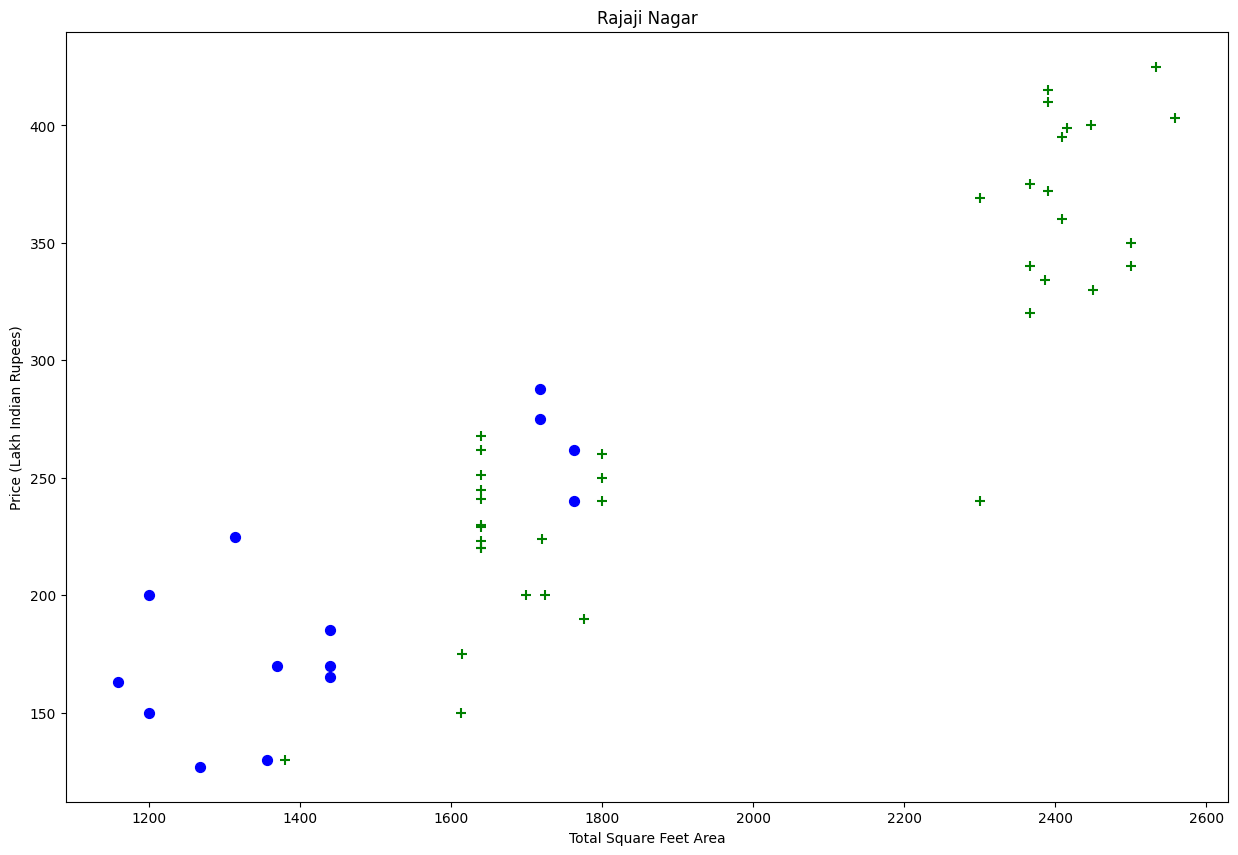

In [71]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+',color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)

plot_scatter_chart(df6,'Rajaji Nagar')

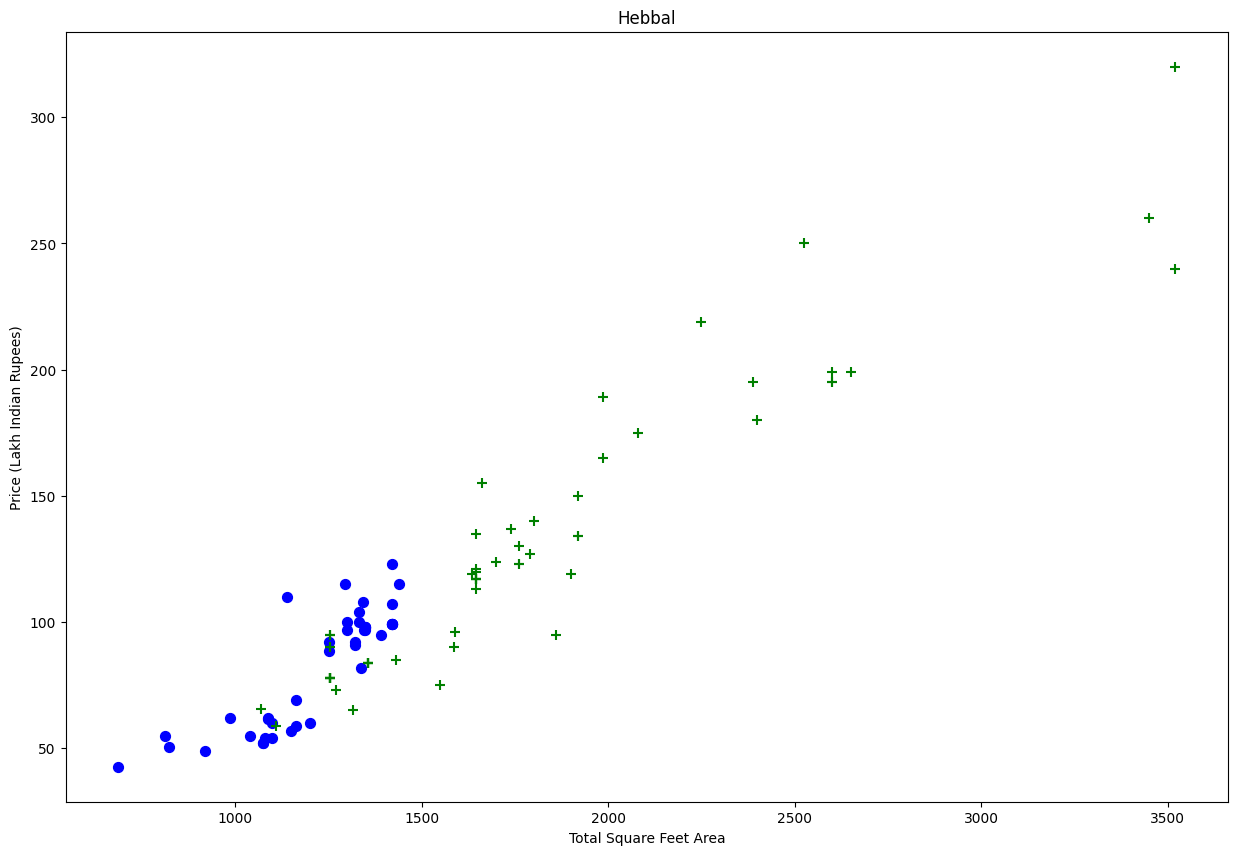

In [72]:
plot_scatter_chart(df6,"Hebbal")

We should also remove properties where for same location, he price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.
```
{
'1' : {
    'mean': 4000,
    'std' : 2000,
    'count': 34
},
'2' : {
    'mean' : 4300,
    'std' : 2300,
    'count' : 22
},
}
```

Now we can remove those 2 BHK apartments whose price-per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [79]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df7 = remove_bhk_outliers(df6)
df7.shape

(7317, 7)

Plot same scatter chart agian to visuliae price_per_sqft for 2 BHK and 3 BHK properties

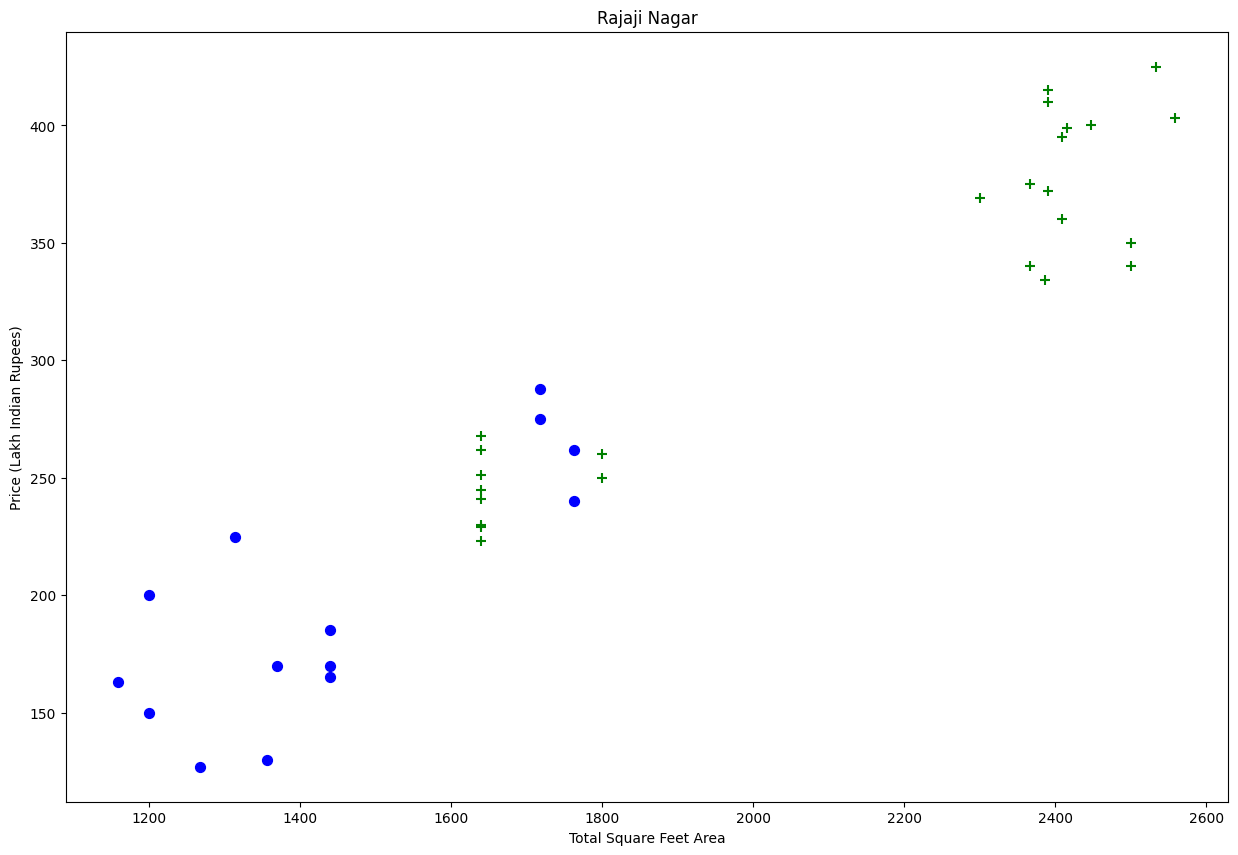

In [80]:
plot_scatter_chart(df7,"Rajaji Nagar")

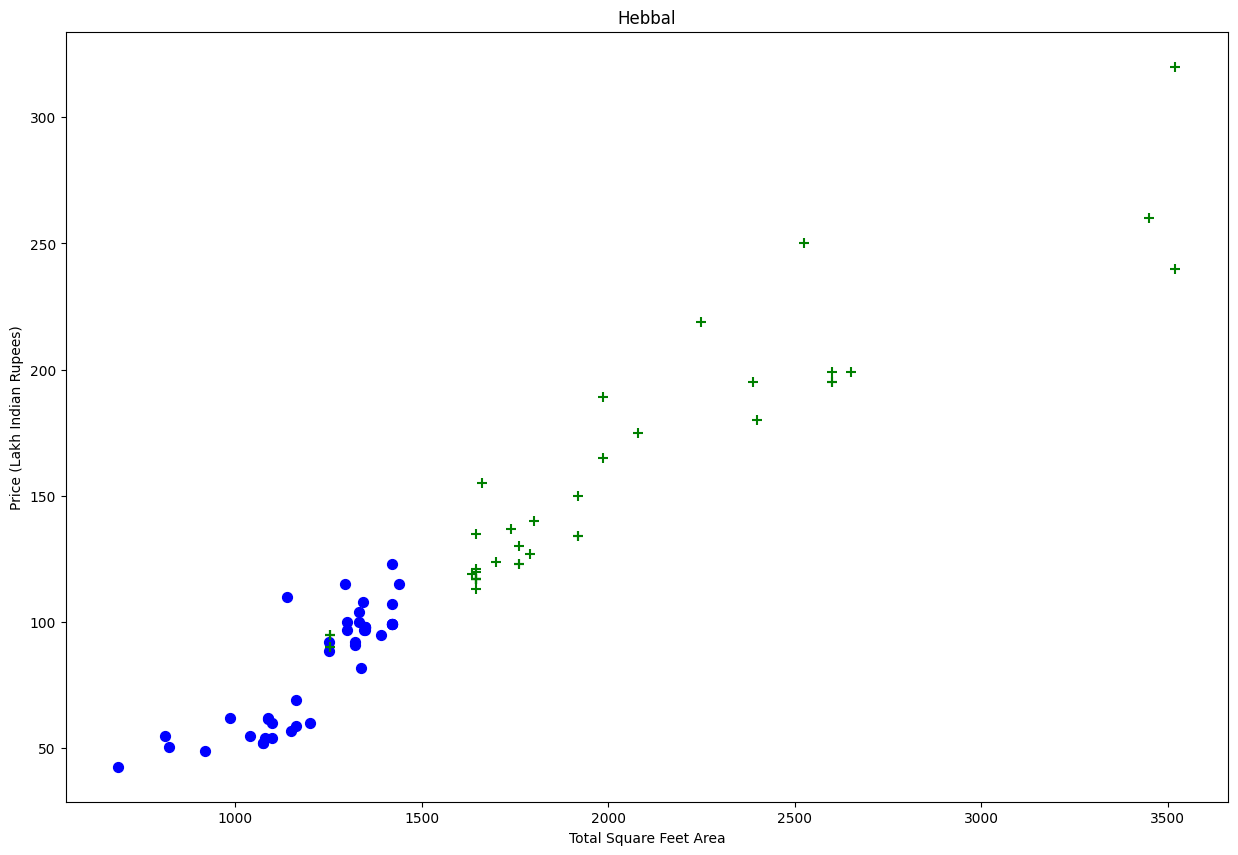

In [82]:
plot_scatter_chart(df7,'Hebbal')

Based on above charts we can see that data points highlighted in red below are ouliers and they are being removed due to remove_bhk_ouliers funtion 

Text(0, 0.5, 'Count')

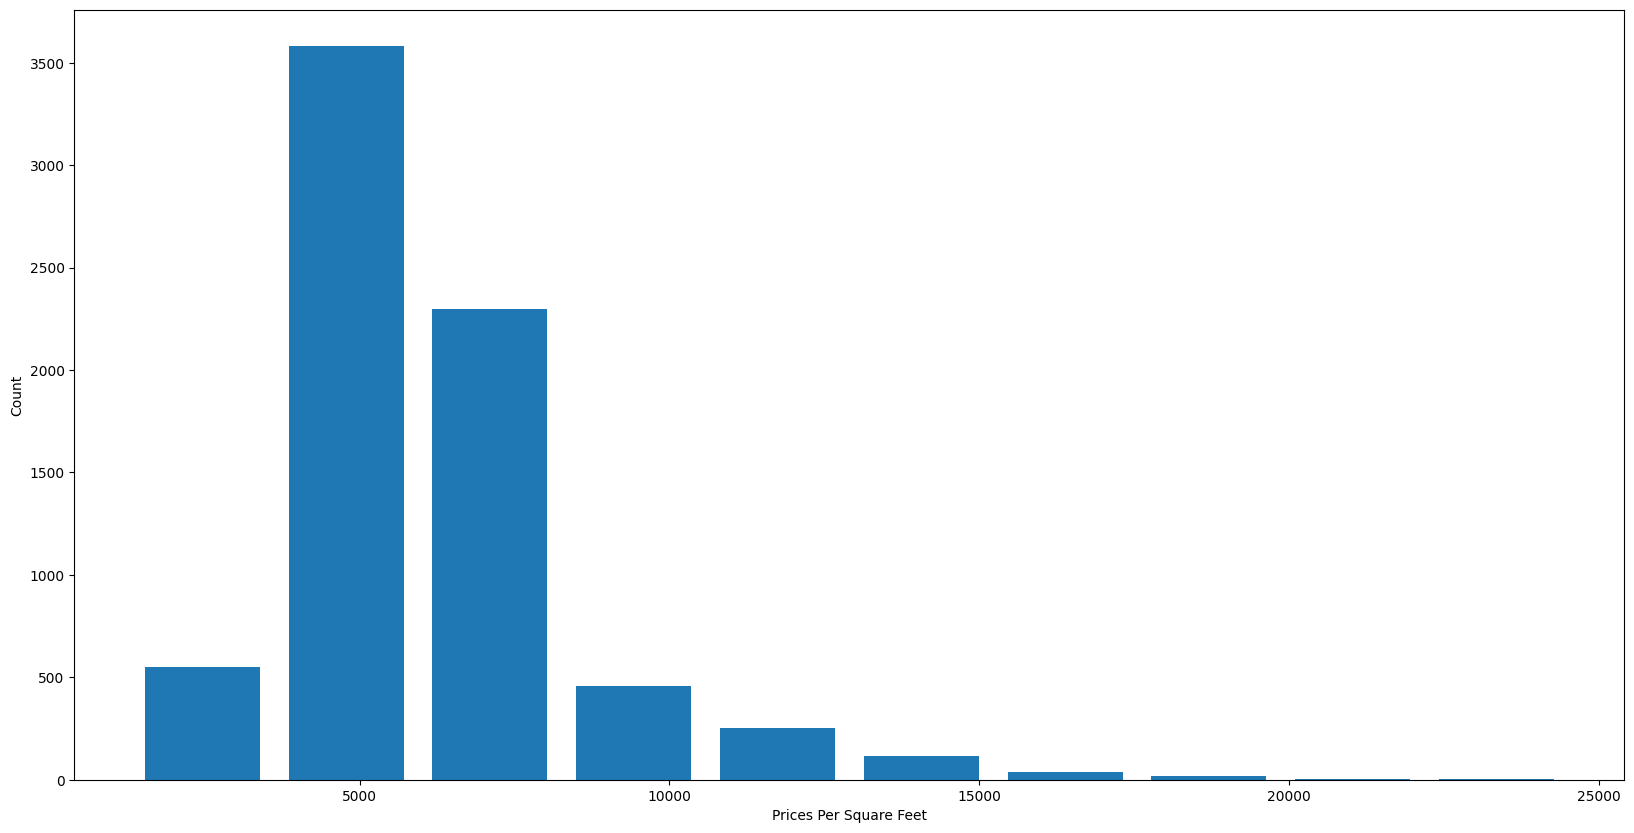

In [83]:
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel('Prices Per Square Feet')
plt.ylabel("Count")

# Outlier Removal Using Bathrooms Feature

In [84]:
df7.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

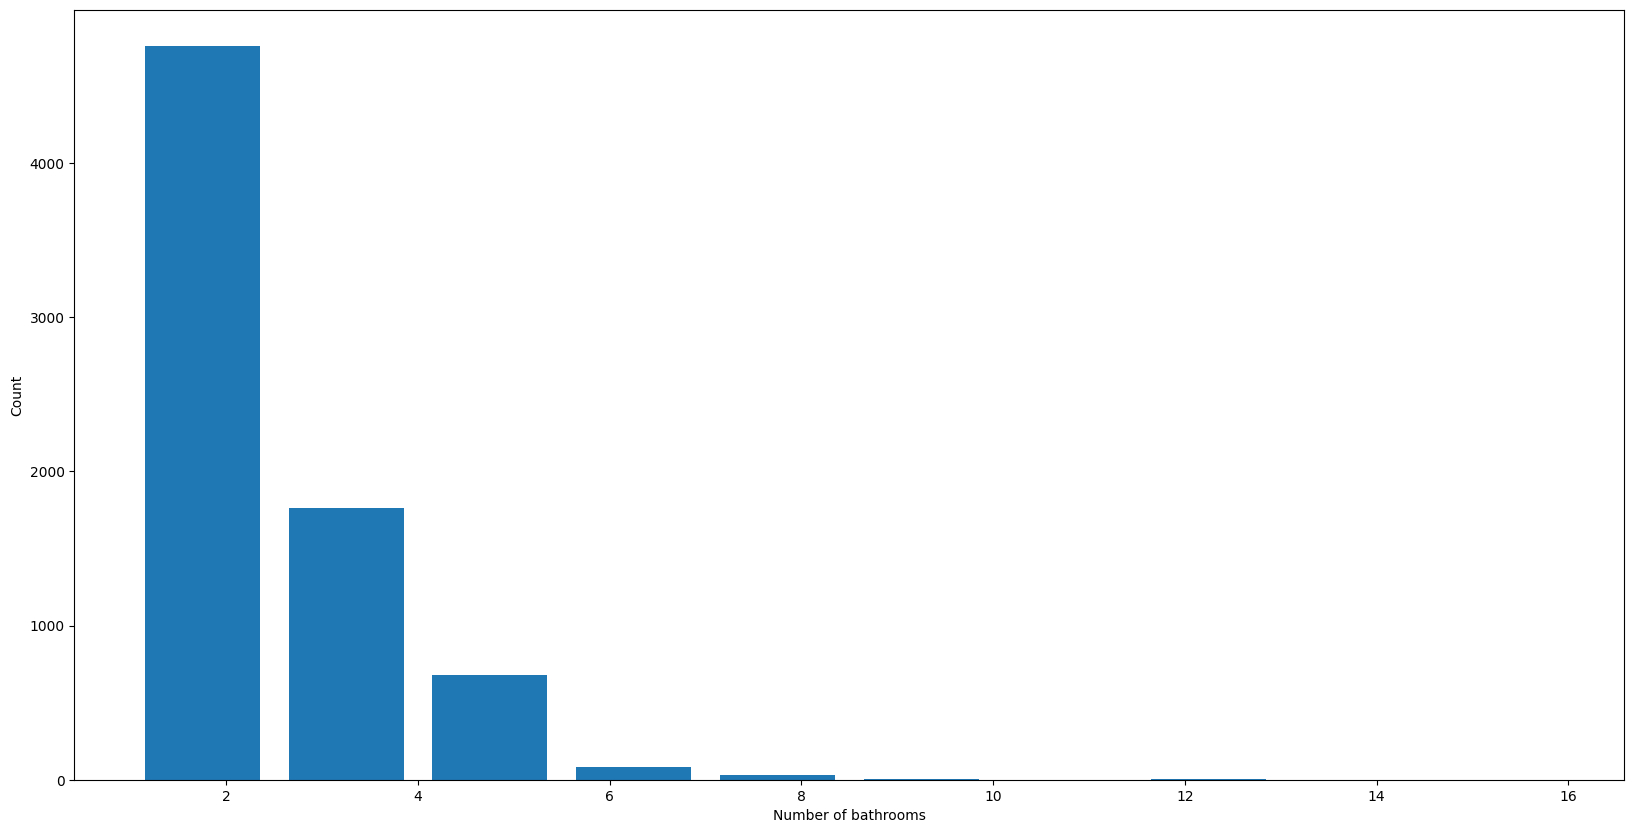

In [86]:
plt.hist(df7.bath,rwidth=0.8)
plt.xlabel('Number of bathrooms')
plt.ylabel('Count')

In [87]:
df7[df7.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


it is unusual to have 2 more bathrooms than number of bedrooms in a home 

In [88]:
df7[df7.bath>df7.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


Again the business has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will ahve total bath = total bed + 1 max. Anythings above that is an outlier or data error and can be removed

In [89]:
df8 = df7[df7.bath<df7.bhk+2]
df8.shape

(7239, 7)

In [90]:
df8.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [92]:
df9 = df8.drop(['size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


Use One Hot Encoding For Location

In [94]:
dummies = pd.get_dummies(df9.location).astype(int)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
df11 = df10.drop('location',axis='columns')
df11.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Build a Model Now

In [100]:
df11.shape

(7239, 244)

In [101]:
X = df11.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X.shape

(7239, 243)

In [104]:
y = df11['price']
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state= 10)

In [107]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8629132245229445

# Use K Fold cross validation to measure accuracy of our LinearRegression model

In [109]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size= 0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

we can see that in 5 iteration we got score above 80% all the time.This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose





# Find best model using GridSearchCV

In [120]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression' : {
            'model':LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'lasso': {
        'model':Lasso(),
        'params':{
            'alpha':[1,2],
            'selection':['random','cyclic']
        }
        },
        'decision_tress': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores =[]
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score':gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


find_best_model_using_gridsearchcv(X,y)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundati

,model,best_score,best_params
0,linear_regression,0.847951,{'fit_intercept': False}
1,lasso,0.726911,"{'alpha': 2, 'selection': 'random'}"
2,decision_tress,0.713128,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


Based on above result we can say that LinearRegression gives the best score. Heance we will use that.

# Test the model for few properties

In [126]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >=0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [127]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(83.86570258311926)

In [128]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(193.31197733179806)

In [129]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(195.52689759854564)

# Export the tested model to a pickle file

In [130]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

# Export location and columns information to a file that will be useful later on in our prediction application

In [131]:
import json
columns = {
    'data_columns': [col.lower() for col in X.columns]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))